# DIABETES LEARNING



In [1]:
import sys; print('Python:',sys.version)
import torch; print('Pytorch:',torch.__version__)
import fastai; print('Fastai:',fastai.__version__)

Python: 3.8.10 (default, Jun  4 2021, 15:09:15) 
[GCC 7.5.0]
Pytorch: 1.10.2+rocm4.2
Fastai: 2.5.3


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
import torch
import torchvision
from PIL import Image

## Data Inspection

In [45]:
path = '/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/'
path_anno = path + 'gt/'
path_img = path + 'done/'

# function that takes ground truth image, given the original image path 

# get_y_fn = lambda originalImagePath : path_anno + '/' + f'{originalImagePath.stem}GT.png' #use for normal /done and /gt folders 
# get_y_fn = lambda originalImagePath : path_anno + '/' + originalImagePath.parent.stem + "/" + f'{originalImagePath.stem}GT.png' #use for aicrowd 
get_y_fn = lambda originalImagePath : path_anno + '/' + originalImagePath.parent.stem + "_ann/" + f'{originalImagePath.stem}.png' #use for MyFood

In [4]:
np.random.seed(2) # same seed
randomSeed = 2

label_fnames = get_image_files(path_anno)
print(label_fnames[:3])
fnames = get_image_files(path_img)
print(fnames[:3])

len(fnames), len(label_fnames)

[Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/gt/test_ann/apple_100.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/gt/test_ann/apple_101.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/gt/test_ann/apple_102.png')]
[Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/done/test/apple_100.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/done/test/apple_101.png'), Path('/mnt/c/Users/bruno/Documents/diabetesLearning/foodDatabase/MyFood/done/test/apple_102.png')]


(1250, 1250)

In [5]:
codes = np.loadtxt(path + 'classesNumber.txt', dtype=str, delimiter='\n',encoding='utf')
# codesId = [code.split(": ")[0] for code in codes]
# codes = [code.split(": ")[1] for code in codes] 
len(codes)

11

/tmp/ipykernel_1381/3771773037.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


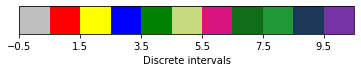

In [6]:
# define colormap for masks

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = matplotlib.colors.ListedColormap([np.random.rand(3,) for i in range(0,len(codes))])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.75, .75, .75, 1.0) 
cmaplist[1] = "red" 
cmaplist[2] = "yellow" 
cmaplist[3] = "blue" 
cmaplist[4] = "green" 

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = [i-0.5 for i in range(0,len(codes)+1)] # intervals must contain integer values, so the bounds should increase every 0.5
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

cb2 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Discrete intervals')
fig.show()

## Iterate data

In [35]:
import cv2

def getThickEdge(mask, rgbValues):
    edge = cv2.Canny(mask*255, 30, 150)

    kernel = np.ones((9,9), np.uint8)
    edge_dilated = cv2.dilate(edge, kernel, iterations=1)

    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[edge_dilated == 255], g[edge_dilated == 255], b[edge_dilated == 255] = rgbValues
    coloured_edge = np.stack([r, g, b], axis=2)

    # fig = plt.figure(figsize=(9,9))
    # ax1 = fig.add_subplot(1,2,1)
    # ax1.imshow(coloured_edge)
    # plt.show()

    return coloured_edge

    
def random_colour_masks(mask):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(mask).astype(np.uint8)
  g = np.zeros_like(mask).astype(np.uint8)
  b = np.zeros_like(mask).astype(np.uint8)
  randomNumber = random.randrange(0,10)
  r[mask == 1], g[mask == 1], b[mask == 1] = colours[randomNumber]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask, colours[randomNumber]

def mergeAndGetClasses(img, mask):
    ids = np.unique(mask) # instances are encoded as different colors
    ids = ids[1:] # first id is the background, so remove it
    classes = [codes[id] for id in ids]
    masks = mask == ids[:, None, None] # split the color-encoded mask into a set of binary masks
    masks = np.asarray(masks, dtype=np.uint8)

    for i in range(len(masks)):
        rgb_mask, rgbValues = random_colour_masks(masks[i])
        edge_mask = getThickEdge(masks[i], rgbValues)
        
        if img.shape != rgb_mask.shape:
            return None, None

        img = cv2.addWeighted(img, 1, rgb_mask, 0.3, 0)
        img = cv2.addWeighted(img, 1, edge_mask, 1, 0)

    return img, classes
    
def getVisualization(fname, returnOriginalMask=False):
    img = cv2.imread(str(fname))
    mask = cv2.imread(str(get_y_fn(fname)), cv2.IMREAD_GRAYSCALE)

    mergedImg, classes = mergeAndGetClasses(img, mask)
    if mergedImg is None:
        print(fname)

    imgs = [cv2.imencode('.jpeg', mergedImg)[1].tobytes()]

    if returnOriginalMask:
        colorMask = cmap(mask, bytes=True)
        imgs.append(cv2.imencode('.jpeg', colorMask)[1].tobytes())
        
    return imgs, classes


    

In [50]:
from IPython.display import display
from ipywidgets import widgets, HBox, VBox, GridBox, Layout

pickedSamples = []
init = 0
end = 10 #len(fnames)

def createButton(file):
    layout = widgets.Layout()
    button = widgets.Button(description='Pick', layout = layout)

    def on_button_clicked(event, file=file):
        pickedSamples.append(file)
        button.description = "Done"
        button.disabled = True

    button.on_click(on_button_clicked)
    return button

items = []
for idx in range(init,end):
    # img = open(fnames[idx], 'rb').read()
    imgs, classes = getVisualization(fnames[idx], returnOriginalMask=True)
    images = [widgets.Image(value=img,width=120,height=120) for img in imgs]
    button = createButton(fnames[idx].name)
    text = widgets.Label(value=str(len(classes)))

    visualization = [text,button] + images
    items.append(VBox(visualization))

grid = GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(8, 160px)"))
display(grid)


GridBox(children=(VBox(children=(Label(value='1'), Button(description='Pick', style=ButtonStyle()), Image(valu…

In [49]:
print(len(pickedSamples))
print(pickedSamples)

0
[]


In [68]:
# save picked images to file

filepath = path + f"pickedImages_init={init}_end={end}.txt"

textfile = open(filepath, "w")
for element in pickedSamples:
    textfile.write(element + "\n")
textfile.close()
